<a href="https://colab.research.google.com/github/linjiw/787/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/24787/hw4

/content/drive/MyDrive/24787/hw4


In [5]:
%ls

digits.mat  hw4.ipynb  MLAI24787_hw04_2022Spring.pdf  test.txt  train.txt


In [23]:
data = sio.loadmat("digits.mat")

x = data['X']
y = np.squeeze(data['y']).reshape((-1,1))

np.place(y,y==10,0) #replace 10 with 0 in labels 
numExamples = x.shape[0] 
numFeaturs = x.shape[1] 
numLabels = 10 #10 class

In [24]:
print(f"numExamples {numExamples} numFeaturs {numFeaturs} numLabels {numLabels} y.shape {y.shape}")

numExamples 5000 numFeaturs 400 numLabels 10 y.shape (5000, 1)


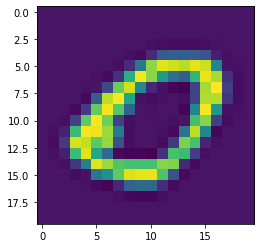

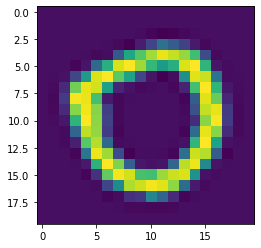

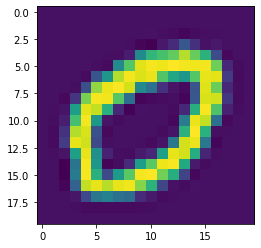

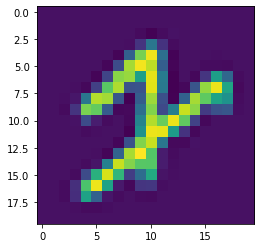

In [12]:
range1 = [0,22,232,2332]

for i in range1:
  pic = x[i,:].reshape((20,20))
  plt.imshow(pic)
  plt.show()


In [27]:
def sigmoid(z):

  return 1 / (1 + np.exp(-z))

def cost(theta, X, y):

  predictions = sigmoid(X @ theta) 
  predictions[predictions == 1] = 0.999 #log(1)=0 causes error in division 
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
  return sum(error) / len(y);

def costGradient(theta, X, y):

  predictions = sigmoid(X @ theta)
  # print(f"predictions.shape {predictions.shape} X.shape {X.shape} X.T @ predictions")
  return X.transpose() @ (predictions - y) / len(y)

In [37]:
def splitdata(x,y):
  train_x = np.empty((0,numFeaturs))
  train_y = np.empty((0,1))
  val_x = np.empty((0,numFeaturs))
  val_y = np.empty((0,1))
  for i in range(10):
    train_x = np.vstack((train_x,x[i*400:(i+1)*400,:]))
    train_y = np.vstack((train_y,y[i*400:(i+1)*400,:]))
    val_x = np.vstack((val_x,x[i*500+400:(i+1)*500,:]))
    # print(val_x.shape)
    val_y = np.vstack((val_y,y[i*500+400:(i+1)*500,:]))
  return train_x,train_y,val_x,val_y

train_x,train_y,val_x,val_y = splitdata(x,y)
print(f"train_x {train_x.shape} train_y {train_y.shape} val_x {val_x.shape} val_y {val_x.shape}")

train_x (4000, 400) train_y (4000, 1) val_x (1000, 400) val_y (1000, 400)


  0%|          | 0/10 [00:00<?, ?it/s]

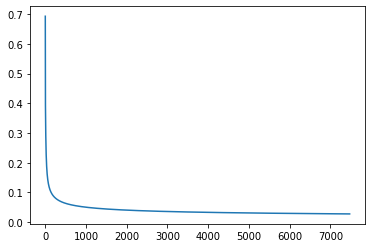

 50%|█████     | 5/10 [05:37<05:50, 70.01s/it]

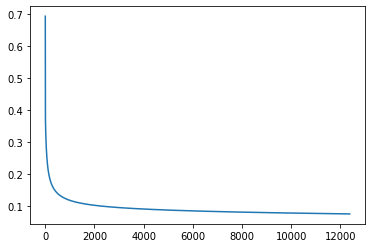

100%|██████████| 10/10 [09:46<00:00, 58.66s/it]


In [42]:
def plotloss(losslst):
    plt.plot(np.arange(len(losslst)), losslst)
    plt.show()
def train(X,Y,class_idx,step=0.1,iter=1e6,threshold=1e-6,e=1e-8,ifplot = False):
    Z = Y.copy()
    Z[Y==class_idx] = 1
    Z[Y!=class_idx] = 0
    error  = 1e5
    count = 0
    prev = 0
    J_lst = []
    # w = np.array([[-65],[0],[0]],dtype=float)
    theta = np.zeros((numFeaturs,1))
    while error > threshold and count<iter:

        J = cost(theta,X,Z)
        G = costGradient(theta,X,Z)
        # print(f"G.shape {G.shape}. theta.shape {theta.shape}")
        theta -= step*G
        error = np.abs(J-prev)
        prev = J
        J_lst.append(J)
        count+=1
        # print(f"loss {J}")
    if ifplot:
      plotloss(J_lst)
    
    return theta

# W = np.zeros((numFeaturs,1))
w_all = dict()
for i in tqdm(range(10)):
  if i==0 or i==5:
    w_all[str(i)] = train(train_x,train_y,i,ifplot=True)
  else:
    w_all[str(i)] = train(train_x,train_y,i,ifplot=False)
np.save('w.npy',w_all)



